# Deutsch Jozsa Algorithm on IonQ Quantum Computers

## Setup

First, get an API key from IonQ. This will be used by the IonQ provider inside Qiskit to submit circuits to the IonQ platform.

After securing an API key, install the python package included with this notebook using `pip`:

```bash
pip install qiskit_ionq_provider-0.0.1.dev0+45bd6b1-py3-none-any.whl
```

(IonQ's adapter for Qiskit is currently in private beta -- your feedback is welcomed!)

### (Optional) Extra Dependencies

Some examples use additional Python dependencies; please make sure to `pip install` them as needed.

Dependencies:
* `matplotlib`: To run `qiskit.visualization.plot_histogram`.

**NOTE**: The provider expects an API key to be supplied via the `token` keyword argument to its constructor. If no token is directly provided, the provider will check for one in the `QISKIT_IONQ_API_TOKEN` environment variable.

Now that the Python package has been installed, you can import and instantiate the provider:

In [1]:
#import Aer here, before calling qiskit_ionq_provider
from qiskit import Aer

from qiskit_ionq_provider import IonQProvider 

provider = IonQProvider(token='My token')


The `provider` instance can now be used to create and submit circuits to IonQ.

### Backend Types

The IonQ provider supports two backend types:
* `ionq_simulator`: IonQ's simulator backend.
* `ionq_qpu`: IonQ's QPU backend.

To view all current backend types, use the `.backends` property on the provider instance:

In [2]:
provider.backends()

[<IonQSimulatorBackend('ionq_simulator') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7fbde8400358>()>,
 <IonQQPUBackend('ionq_qpu') from <qiskit_ionq_provider.ionq_provider.IonQProvider object at 0x7fbde8400358>()>]

Define a function to construct the circuit based on the number of bits in the function and whether the function is of constant or balanced type.

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import math

def deutsch_jozsa_circuit(n, f_type):
    num_qubits=n+2
    qc = QuantumCircuit(num_qubits, num_qubits)

    for i_qubit in range(num_qubits-2):
        qc.ry(math.pi/2., i_qubit)

    qc.ry(-1.*math.pi/2., num_qubits-1)

    if f_type=='constant':
        pass
    elif f_type=='balanced':
        for i_qubit in range(n):
            qc.cx(i_qubit, n)
    else:
        sys.exit("Unknown function type")

    qc.cx(num_qubits-2, num_qubits-1)

    for i_qubit in range(num_qubits):
        qc.ry(math.pi/2., i_qubit)
    
    qc.measure(range(num_qubits), range(num_qubits))

    return qc

In [4]:
n=4
f_type='constant'

qc=deutsch_jozsa_circuit(n, f_type)

# Show the circuit:
qc.draw()

┌─────────┐ ┌─────────┐           ┌─┐               
q_0: ┤ RY(π/2) ├─┤ RY(π/2) ├───────────┤M├───────────────
     ├─────────┤ ├─────────┤           └╥┘┌─┐            
q_1: ┤ RY(π/2) ├─┤ RY(π/2) ├────────────╫─┤M├────────────
     ├─────────┤ ├─────────┤            ║ └╥┘┌─┐         
q_2: ┤ RY(π/2) ├─┤ RY(π/2) ├────────────╫──╫─┤M├─────────
     ├─────────┤ ├─────────┤            ║  ║ └╥┘┌─┐      
q_3: ┤ RY(π/2) ├─┤ RY(π/2) ├────────────╫──╫──╫─┤M├──────
     └─────────┘ └─────────┘┌─────────┐ ║  ║  ║ └╥┘┌─┐   
q_4: ─────────────────■─────┤ RY(π/2) ├─╫──╫──╫──╫─┤M├───
     ┌──────────┐   ┌─┴─┐   ├─────────┤ ║  ║  ║  ║ └╥┘┌─┐
q_5: ┤ RY(-π/2) ├───┤ X ├───┤ RY(π/2) ├─╫──╫──╫──╫──╫─┤M├
     └──────────┘   └───┘   └─────────┘ ║  ║  ║  ║  ║ └╥┘
c: 6/═══════════════════════════════════╩══╩══╩══╩══╩══╩═
                                        0  1  2  3  4  5

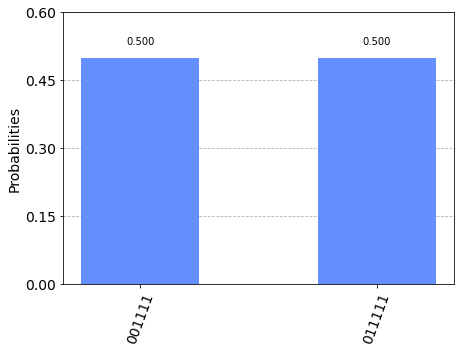

In [5]:
# Get an IonQ simulator backend to run circuits on:
backend = provider.get_backend("ionq_simulator")

#Run the circuit on the simulator and plot the results
job = backend.run(qc)

#save job_id
job_id_1 = job.job_id()

#Fetch the result:
result = job.result()

#Plot the result. Conditioned on the qubit n being in the 1 state, measurement of the output {q1 q2...qn} = {11...1} indicates a constant function, while any other value indicates a balanced function.
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts())

On the quantum computer, one can see how the performance changes with the number of bits.

In [6]:

# Get an IonQ hardware backend to run circuits on:
backend = provider.get_backend("ionq_qpu")

job_id_store=[]
for n in range(2,5):
    for f_type in ['constant', 'balanced']:
        #Create the circuit
        qc=deutsch_jozsa_circuit(n, f_type)

        #Submit the job
        job = backend.run(qc)

        #save job_id
        job_id_store.append(job.job_id())

Keep checking job statuses till all are done and plot histograms

In [23]:
from qiskit.providers.jobstatus import JobStatus
import time

result_store=[]
for job_id in job_id_store:
    
    job=backend.retrieve_job(job_id)
    while job.status() is not JobStatus.DONE:
        time.sleep(5)

    result_store.append(job.result())    

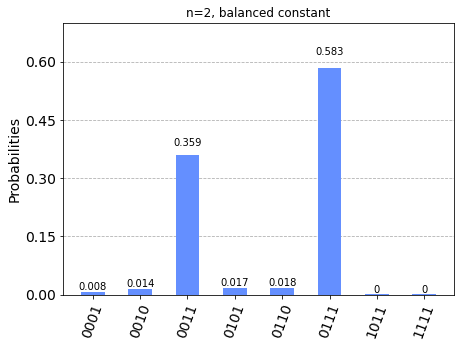

In [29]:
plot_histogram(result_store[0].get_counts(), title='n=2, constant')

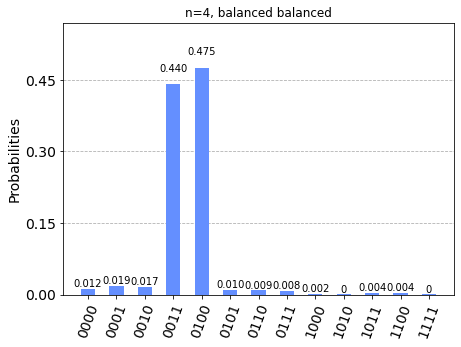

In [30]:
plot_histogram(result_store[1].get_counts(), title='n=2, balanced')

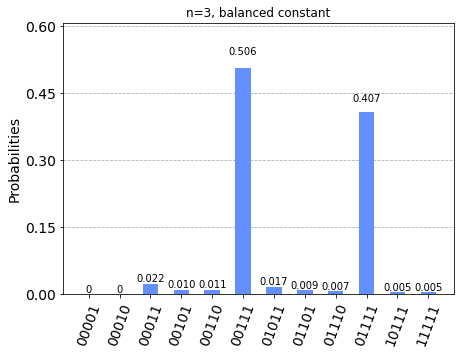

In [31]:
plot_histogram(result_store[2].get_counts(), title='n=3, constant')

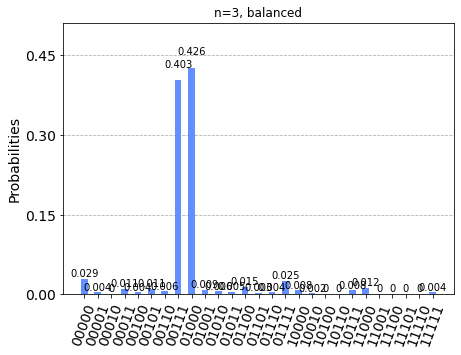

In [32]:
plot_histogram(result_store[3].get_counts(), title='n=3, balanced')